# Training Pipeline for Dance Video

Complete training pipeline for dance video. (to be converted to .py file later)

**Workflow:**
1. Run video_into_frame script to extract all the frames (optional)
2. Frames to landmarks csv using mediapipe written by Harris
3. Run K-NN algorithm to cluster the image landmarks and visualize in 2D (dimension reduction)
   1. Clean the additional data
4. LABEL moves using K-NN output as reference
5. Run lazyprediction to select the best model (optional)
6. Fit the best model to classify labels
7. Evalute & save model to pickel files

## Extract Frames From Video

Run this only once to get necessary data.

In [1]:
import cv2
import pafy

import os
import shutil
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import itertools
import mediapipe as mp

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
# # take environment variables from .env.
# load_dotenv()
# pafy.set_api_key(os.getenv("GOOGLE_API"))

# def extractImages(pathIn):
#     # Config temporary directory path for storing video frames
#     TEMP_DIR = "temp/"

#     count = 1
#     video = pafy.new(pathIn)

#     # Log metadata from video (pafy object)
#     print(f"Video title: {video.title}")
#     print(f"Video length in seconds: {video.length}")
#     print(f"Video category: {video.category}")
#     print(f"Video keywords: {video.keywords}")

#     best = video.getbest(preftype="mp4")
#     vidcap = cv2.VideoCapture(best.url)
#     success, image = vidcap.read()
#     print(f"Successfully read video metadata from the link. Start capturing frames.")

#     # Create temp/ directory for storage
#     try:
#         os.mkdir(TEMP_DIR)
#     except FileExistsError:
#         print(f"FileExistsError: Temporary directory already exists. Removing the directory beofre creating a new one.")
#         shutil.rmtree(TEMP_DIR)	
#         os.mkdir(TEMP_DIR)

#     success = True
#     while success:
#         vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000)) 
#         success,image = vidcap.read()
#         print (f'Read a new frame {count}: ', success)

#         try:
#             cv2.imwrite(TEMP_DIR + "/frame%d.jpg" % count, image)     # save frame as JPEG file
#         except Exception as e:
#             break
#         count = count + 1

# extractImages("https://www.youtube.com/watch?v=Ef3zmMC0pxs")


## Frames to Landmark

In [7]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [8]:
# Landmark enums (check data)
pose_enums_dict = {pose_enum.name: pose_enum.value for pose_enum in mp_pose.PoseLandmark}
pose_enums_array = list(pose_enums_dict.keys())
pose_enums_dict

{'NOSE': 0,
 'LEFT_EYE_INNER': 1,
 'LEFT_EYE': 2,
 'LEFT_EYE_OUTER': 3,
 'RIGHT_EYE_INNER': 4,
 'RIGHT_EYE': 5,
 'RIGHT_EYE_OUTER': 6,
 'LEFT_EAR': 7,
 'RIGHT_EAR': 8,
 'MOUTH_LEFT': 9,
 'MOUTH_RIGHT': 10,
 'LEFT_SHOULDER': 11,
 'RIGHT_SHOULDER': 12,
 'LEFT_ELBOW': 13,
 'RIGHT_ELBOW': 14,
 'LEFT_WRIST': 15,
 'RIGHT_WRIST': 16,
 'LEFT_PINKY': 17,
 'RIGHT_PINKY': 18,
 'LEFT_INDEX': 19,
 'RIGHT_INDEX': 20,
 'LEFT_THUMB': 21,
 'RIGHT_THUMB': 22,
 'LEFT_HIP': 23,
 'RIGHT_HIP': 24,
 'LEFT_KNEE': 25,
 'RIGHT_KNEE': 26,
 'LEFT_ANKLE': 27,
 'RIGHT_ANKLE': 28,
 'LEFT_HEEL': 29,
 'RIGHT_HEEL': 30,
 'LEFT_FOOT_INDEX': 31,
 'RIGHT_FOOT_INDEX': 32}

In [9]:
def get_final_dataset_columns():
    products_join = [pose_enums_array, ["X", "Y"]]
    landmark_columns = ["{}_{}".format(column_name_tuple[0], column_name_tuple[1])
    for column_name_tuple in list(itertools.product(*products_join))]
    final_columns = ["IMAGE"] + landmark_columns + ["LABEL"] 
    return final_columns

class LandmarkProcessor():

  def __init__(self):
    self.image_dataset = []

  def get_final_dataset(self):
    '''
      Write this out to csv
    '''
    return self.image_dataset
    
  def add_images_to_final_dataset(self, path : str, label : str):
    '''
      Name: add_images_to_final_dataset
      Description: Derive landmark information from images in one directory and add their information
      to the final dataset
      Input: 
        path -> full path to image folder
        label -> label/category of images under the image folder
    '''
    
    for image_name in os.listdir(path):
      image_attr = []

      image_path = os.path.join(path, image_name)
      image = cv2.imread(image_path)
      landmark_poses = self.get_landmarks(image)
      image_attr.append(image_name)

      if landmark_poses is not None:
        landmark_array = landmark_poses.landmark
        for landmark_data in landmark_array:
          image_attr.append(landmark_data.x)
          image_attr.append(landmark_data.y)
      else:
        image_attr.extend([None, None])

      image_attr.append(label)
      self.image_dataset.append(image_attr)


  def get_landmarks(self, image) -> list:
    '''
      Name: get_landmarks
      Input: image (returned from cv2.imread)
      Returns: list of landmarks (33 features)
    '''
    with mp_pose.Pose(
        static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # mp_drawing.draw_landmarks(
        #     image,
        #     results.pose_landmarks,
        #     mp_pose.POSE_CONNECTIONS,
        #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        return results.pose_landmarks
        # Print nose landmark.
        # image_hight, image_width, _ = image.shape
        # if results.pose_landmarks:
        #   print(
        #     f'Nose coordinates: ('
        #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_hight})'
        #   )

        # Draw pose landmarks.
        # print(f'Pose landmarks for {image}:')
        # annotated_image = image.copy()

        # mp_drawing.draw_landmarks(
        #     image,
        #     results.pose_landmarks,
        #     mp_pose.POSE_CONNECTIONS,
        #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        # resize_and_show(annotated_image)


In [10]:
DATA_PATH = "./temp"
Processor = LandmarkProcessor()
Processor.add_images_to_final_dataset(DATA_PATH, label=np.nan)

# Putting together final pandas DataFrame
df = pd.DataFrame(Processor.image_dataset, columns=get_final_dataset_columns())
print(df.shape)
df.head()

(914, 68)


,IMAGE,NOSE_X,NOSE_Y,LEFT_EYE_INNER_X,LEFT_EYE_INNER_Y,LEFT_EYE_X,LEFT_EYE_Y,LEFT_EYE_OUTER_X,LEFT_EYE_OUTER_Y,RIGHT_EYE_INNER_X,...,RIGHT_ANKLE_Y,LEFT_HEEL_X,LEFT_HEEL_Y,RIGHT_HEEL_X,RIGHT_HEEL_Y,LEFT_FOOT_INDEX_X,LEFT_FOOT_INDEX_Y,RIGHT_FOOT_INDEX_X,RIGHT_FOOT_INDEX_Y,LABEL
0,frame1.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,frame10.jpg,0.555052,0.322708,0.558210,0.315679,0.560906,0.316910,0.563302,0.318219,0.551880,...,0.798478,0.577361,0.813119,0.551599,0.805392,0.578563,0.848539,0.543347,0.837895,NaN
2,frame100.jpg,0.540711,0.311518,0.544974,0.297285,0.548448,0.295432,0.551287,0.293891,0.539554,...,0.435520,0.599891,0.361303,0.595630,0.436402,0.583105,0.361809,0.565872,0.438211,NaN
3,frame101.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,frame102.jpg,0.519434,0.319385,0.519909,0.306906,0.521758,0.304778,0.523989,0.302357,0.517363,...,0.765305,0.513245,0.766883,0.582439,0.793299,0.475027,0.767517,0.537805,0.798864,NaN


In [ ]:
# df.to_csv("./data/unlabelled.csv", index=False)

## K-Means Clustering

In [13]:
# Drop rows that have empty landmarks
clabels = df.columns
df = df.dropna(axis=0, subset=clabels[1:-1])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861 entries, 1 to 913
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMAGE               861 non-null    object 
 1   NOSE_X              861 non-null    float64
 2   NOSE_Y              861 non-null    float64
 3   LEFT_EYE_INNER_X    861 non-null    float64
 4   LEFT_EYE_INNER_Y    861 non-null    float64
 5   LEFT_EYE_X          861 non-null    float64
 6   LEFT_EYE_Y          861 non-null    float64
 7   LEFT_EYE_OUTER_X    861 non-null    float64
 8   LEFT_EYE_OUTER_Y    861 non-null    float64
 9   RIGHT_EYE_INNER_X   861 non-null    float64
 10  RIGHT_EYE_INNER_Y   861 non-null    float64
 11  RIGHT_EYE_X         861 non-null    float64
 12  RIGHT_EYE_Y         861 non-null    float64
 13  RIGHT_EYE_OUTER_X   861 non-null    float64
 14  RIGHT_EYE_OUTER_Y   861 non-null    float64
 15  LEFT_EAR_X          861 non-null    float64
 16  LEFT_EAR

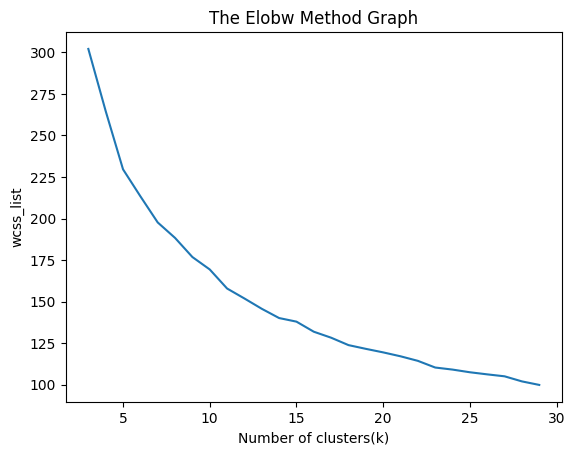

In [15]:
# Finding optimal number of clusters using the elbow method  
from sklearn.cluster import KMeans  

wcss_list= []  #Initializing the list for the values of WCSS  
X = df.drop(["IMAGE", "LABEL"], axis=1).to_numpy()
X = X.astype("float")

for i in range(3, 30):  
    kmeans = KMeans(n_clusters=i, n_init="auto", init='k-means++', random_state= 42) # Model
    kmeans.fit(X)  # Training
    wcss_list.append(kmeans.inertia_)

plt.plot(range(3, 30), wcss_list)  
plt.title('The Elobw Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('wcss_list')  
plt.show()

In [16]:
# training the K-means model on a dataset with optimal n_cluster
optimal_cluster = 15
kmeans = KMeans(n_clusters=optimal_cluster, n_init="auto", init='k-means++', random_state= 42)  
y_pred= kmeans.fit_predict(X)
print(y_pred.shape)
y_pred[:5]

(861,)


array([13, 10,  7,  7, 11])

In [17]:
# Cluster distribution
pd.Series(y_pred).value_counts().sort_index()

0      56
1      58
2      87
3      85
4      44
5      54
6      80
7      79
8      43
9       4
10     15
11     86
12     29
13    103
14     38
dtype: int64

In [18]:
def draw_landmarks(image):
    '''
        Name: draw_landmarks
        Input: image (returned from cv2.imread)
        Returns: Draw all landmarks on images (33 features)
    '''
    with mp_pose.Pose(
        static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Draw pose landmarks
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        # resize_and_show(annotated_image)
        return image
        

# Exploration: visualize some images from each cluster (optional)

In [ ]:

df["LABEL_PRED"] = y_pred
samples = {}

for i in range(1,15):
    df_filter = df[df["LABEL_PRED"] == i]
    df_filter = df_filter.sample(10)
    image_fnames = list(df_filter["IMAGE"])
    samples[i] = image_fnames

# Visualize the cluster in n_cluster rows x 10 grid for helping exploring the dance moves
fig, axs = plt.subplots(optimal_cluster, 10, figsize=(24, 24))
# turn off axes for all subplots:
[axi.set_axis_off() for axi in axs.ravel()]

for i, (k, fnames) in enumerate(samples.items()):
    for j, fname in enumerate(fnames):
        img = plt.imread(DATA_PATH + fname)
        annotated_img = draw_landmarks(img)
        axs[i, j].imshow(annotated_img)

plt.show()

        

## Get Labelled Landmarks CSV

Loop through the data directories and convert all image files into landmarks and append to a DataFrame.

The file structure should be:  
- training_data  
    - label1  
    - label2  
    - ...  
    - labeln  

In [56]:
TRAIN_TEST_PATH = "./data/train_test_data"
# initialize a new object
Processor = LandmarkProcessor()

for dir in os.listdir(TRAIN_TEST_PATH):
    print(f"label: {dir}")
    Processor.add_images_to_final_dataset(f"{TRAIN_TEST_PATH}/{dir}/original", label=dir)

# Putting together final pandas DataFrame
df = pd.DataFrame(Processor.image_dataset, columns=get_final_dataset_columns())
print(df.shape)
df.head()


label: 0_ready_1
label: 12_rising_hands
label: 1_cover_face
label: 2_left_kick
label: 6_chicken_arms_maybe_kicks
label: 8_strong_cover_face
(372, 68)


,IMAGE,NOSE_X,NOSE_Y,LEFT_EYE_INNER_X,LEFT_EYE_INNER_Y,LEFT_EYE_X,LEFT_EYE_Y,LEFT_EYE_OUTER_X,LEFT_EYE_OUTER_Y,RIGHT_EYE_INNER_X,...,RIGHT_ANKLE_Y,LEFT_HEEL_X,LEFT_HEEL_Y,RIGHT_HEEL_X,RIGHT_HEEL_Y,LEFT_FOOT_INDEX_X,LEFT_FOOT_INDEX_Y,RIGHT_FOOT_INDEX_X,RIGHT_FOOT_INDEX_Y,LABEL
0,frame123.jpg,0.44,0.21,0.44,0.16,0.45,0.16,0.46,0.16,0.41,...,1.16,0.51,1.20,0.40,1.19,0.47,1.31,0.41,1.23,0_ready_1
1,frame143.jpg,0.42,0.34,0.42,0.33,0.43,0.33,0.43,0.33,0.42,...,0.83,0.43,0.86,0.41,0.84,0.43,0.92,0.41,0.89,0_ready_1
2,frame146.jpg,0.45,0.35,0.46,0.34,0.46,0.35,0.46,0.35,0.45,...,0.92,0.50,0.91,0.36,0.94,0.50,0.96,0.34,0.98,0_ready_1
3,frame161.jpg,0.49,0.35,0.49,0.33,0.50,0.33,0.50,0.33,0.48,...,1.05,0.53,1.07,0.49,1.07,0.54,1.11,0.47,1.10,0_ready_1
4,frame162.jpg,0.48,0.44,0.49,0.43,0.49,0.43,0.49,0.43,0.48,...,0.92,0.51,0.98,0.48,0.93,0.51,1.01,0.47,0.97,0_ready_1


## Export images to cluster directories


In [20]:
df.loc[:, "LABEL_PRED"] = y_pred
df.head()

,IMAGE,NOSE_X,NOSE_Y,LEFT_EYE_INNER_X,LEFT_EYE_INNER_Y,LEFT_EYE_X,LEFT_EYE_Y,LEFT_EYE_OUTER_X,LEFT_EYE_OUTER_Y,RIGHT_EYE_INNER_X,...,LEFT_HEEL_X,LEFT_HEEL_Y,RIGHT_HEEL_X,RIGHT_HEEL_Y,LEFT_FOOT_INDEX_X,LEFT_FOOT_INDEX_Y,RIGHT_FOOT_INDEX_X,RIGHT_FOOT_INDEX_Y,LABEL,LABEL_PRED
1,frame10.jpg,0.555052,0.322708,0.558210,0.315679,0.560906,0.316910,0.563302,0.318219,0.551880,...,0.577361,0.813119,0.551599,0.805392,0.578563,0.848539,0.543347,0.837895,NaN,13
2,frame100.jpg,0.540711,0.311518,0.544974,0.297285,0.548448,0.295432,0.551287,0.293891,0.539554,...,0.599891,0.361303,0.595630,0.436402,0.583105,0.361809,0.565872,0.438211,NaN,10
4,frame102.jpg,0.519434,0.319385,0.519909,0.306906,0.521758,0.304778,0.523989,0.302357,0.517363,...,0.513245,0.766883,0.582439,0.793299,0.475027,0.767517,0.537805,0.798864,NaN,7
6,frame104.jpg,0.504279,0.307254,0.504707,0.294500,0.506623,0.292026,0.508776,0.289260,0.501918,...,0.589917,0.665963,0.499924,0.766002,0.575580,0.737114,0.475214,0.794503,NaN,7
7,frame105.jpg,0.367813,0.407505,0.369936,0.395775,0.372886,0.394489,0.375528,0.393954,0.364639,...,0.505450,0.802909,0.351544,0.756118,0.518645,0.819542,0.323779,0.763254,NaN,11


# Define Clusters
clusters = [i for i in range(df["LABEL_PRED"].max() + 1)]

# Make directory of clusters
os.makedirs('clusters', exist_ok=False)
for i in clusters:
      os.makedirs('clusters/{}'.format(i))

# Find each image in the dataframe in the DATA_PATH directory, and redirect it to clusters. 
for i in range(df.shape[0]):
      image_name, predicted_label = df.iloc[i].loc[["IMAGE", "LABEL_PRED"]]
      img = cv2.imread(os.path.join(DATA_PATH, image_name))
      annotated_img = draw_landmarks(img)
      
      annotatedPath = os.path.join('clusters', str(predicted_label), "annotated", image_name)
      cv2.imwrite(annotatedPath, annotated_img)

      originalPath = os.path.join('clusters', str(predicted_label), 'original', image_name)
      cv2.imwrite(originalPath, img)

## Training Classifier

In [61]:
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import pandas as pd
import numpy as np

In [62]:
# Drop rows that have empty landmarks
clabels = df.columns
df = df.dropna(axis=0)

X = df.iloc[:, 1:-1].astype("float").to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)

# Encode y into numerical labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Imputing missing values AFTER the data split
X_train = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train)
X_test = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_test)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(y_pred)

from sklearn.metrics import classification_report
target_names = os.listdir(TRAIN_TEST_PATH)
print(classification_report(y_test, y_pred, target_names=target_names))

[0 0 2 2 0 3 5 0 4 0 0 0 2 4 4 4 4 4 4 4 5 2 2 0 0 0 5 0 3 4 0 4 0 0 0 0 0
 4 4 4 0 4 0 0 1 4 2 0 0 0 0 0 0 2 2 0 3 0 0 2 4 0 2 2 3 3 0 4 0 2 4 0 4 0
 0 2 0 0 2 0 0 4 4 5 2 0 4 1 0 1 4 1 0 5 0 0 0 4 0 4 0 5 4 0 4 0 4 0 4 0 0
 4 2 3 0 0 0 4 5 0 3 2 5 0 0 5 0 3 0 0 4 4 0 3 4 4 5 5 5 0 2 5 0 5 0 0 2 3
 0 0 0 2 0 0 5 0 0 0 0 2 5 2 4 3 0 4 0 4 2 4 0 0 5 0 4 2 4 0 0 0 0 4 2 0 0
 0]
                            precision    recall  f1-score   support

                 0_ready_1       0.80      0.91      0.85        77
           12_rising_hands       1.00      0.36      0.53        11
              1_cover_face       0.76      0.86      0.81        22
               2_left_kick       0.00      0.00      0.00        14
6_chicken_arms_maybe_kicks       0.81      0.77      0.79        44
       8_strong_cover_face       0.94      0.89      0.91        18

                  accuracy                           0.77       186
                 macro avg       0.72      0.63      0.65       186
       

In [63]:
# Save the model to a pkl file for deployment
import pickle
pickle.dump(clf, open("./models/classifier.pkl", 'wb'))

In [33]:
# Define Clusters
clusters = [i for i in range(df["LABEL_PRED"].max() + 1)]

# Make directory of clusters
os.makedirs('clusters', exist_ok=False)
for i in clusters:
      os.makedirs('clusters/{}'.format(i))

# Find each image in the dataframe in the DATA_PATH directory, and redirect it to clusters. 
for i in range(df.shape[0]):
      image_name, predicted_label = df.iloc[i].loc[["IMAGE", "LABEL_PRED"]]
      img = cv2.imread(os.path.join(DATA_PATH, image_name))
      annotated_img = draw_landmarks(img)
      
      toPath = os.path.join('clusters', str(predicted_label), image_name)
      cv2.imwrite(toPath, annotated_img)